# Lab 4

## Getting Data and HD5

In [1]:
# Imports
%matplotlib inline
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import scipy
from scipy import stats
import h5py

#this sets the size of the plot to something useful
plt.rcParams["figure.figsize"] = (20, 15)

In [2]:
hf = h5py.File('gammaray_lab4.h5', 'r')
hf.keys()

<KeysViewHDF5 ['data']>

In [3]:
data = np.array(hf.get('data'))
data[:, 0]

array([9.40680016e+08, 3.15000000e+02, 4.50000000e+01, 1.00000000e+01])

In [4]:
hf.close()

## Problem 1

In this problem we are looking at the data from a gamma-ray satellite orbiting in low Earth orbit. It takes a reading of the number of particles detected every 100 milliseconds, and is in an approximately 90 minute orbit. While it is looking for gamma-ray bursts, virtually all of the particles detected are background cosmic rays.

As with most data, there are 'features.' Your lab instructor has helpfully incorporated the meta-data into your data file.

1) Down load the data from the course website (gammaray_lab4.h5), and import it into your working environment. The data has 4 columns and more than 25 million rows. The columns are time (in gps seconds), Solar phase (deg) showing the position of the sun relative to the orbit, Earth longitude (deg) giving the position of the spacecraft relative to the ground, and particle counts. Make a few plots, generally exploring your data and making sure you understand it. Give a high level description of the data features you see. Specifically comment on whether you see signal contamination in your data, and how you plan to build a background pdf().

In [5]:
time = data[0, :]
solar_phase = data[1, :]
longitude = data[2, :]
particle_count = data[3, :]

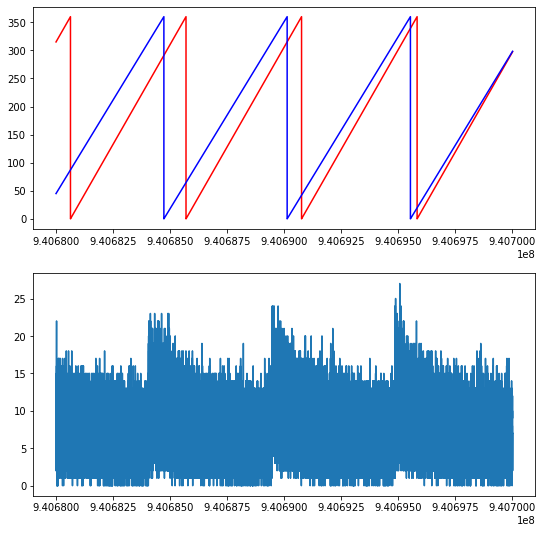

In [9]:
#Lets plot some pieces of the data set early and later.
count=200000
early_time = time[0:count]
early_solar = solar_phase[0:count]
early_longitude = longitude[0:count]
early_particles = particle_count[0:count]

figure = plt.figure(figsize=(9, 9))
axes = figure.subplots(2, 1)

# These are cycling through 0 to 360 degrees
axes[0].plot(early_time, early_solar, 'r'); #red line
axes[0].plot(early_time, early_longitude, 'b'); #blue line
axes[0].set_xlabel("Time (gps seconds)")
axes[0].set_ylabel("Degrees")

# This one has some weird jumps up
axes[1].step(early_time, early_particles, where='mid');
axes[1].set_xlabel("Time (gps seconds)")
axes[1].set_ylabel("Particle count")

Looking at these graphs, the particle count and the longitude seem to have similar periods, so lets graph a section of those two together.

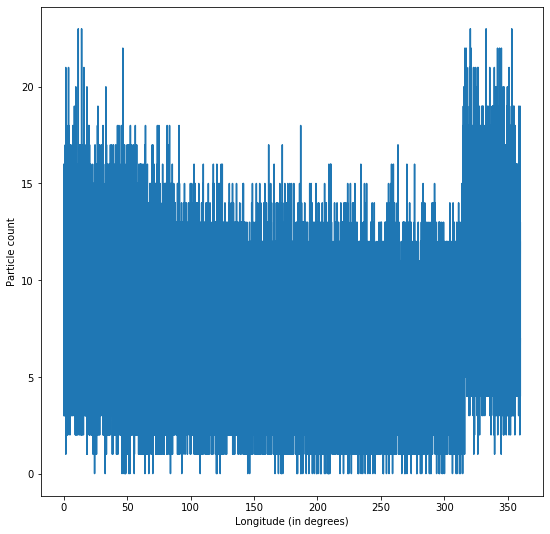

In [12]:
figure = plt.figure(figsize=(9,9))
ax = figure.subplots()

count = 60000
x = longitude[0:count]
particles = particle_count[0:count]
ax.plot(x, particles);
ax.set_ylabel("Particle count");
ax.set_xlabel("Longitude (in degrees)");

Lets do some histograms for different longitudes versus particle count and see what we get over all the times.

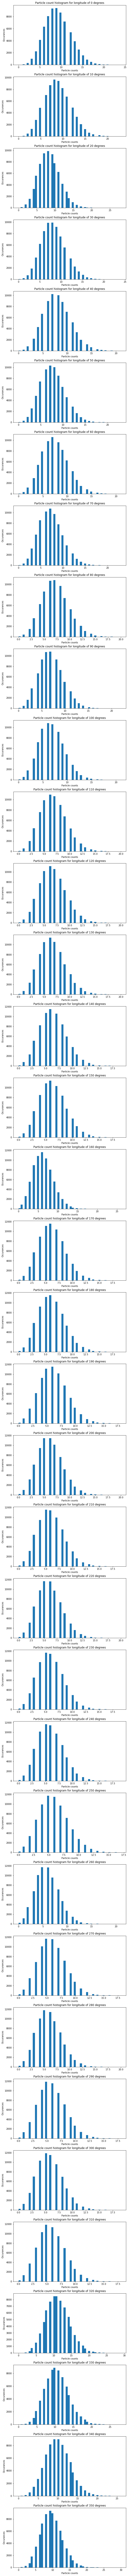

In [35]:
# Tweakables
degree_steps = 10

# Calculated
plots = int(round(360 / degree_steps))
figure = plt.figure(figsize=(9, 4.5*plots))
figure.subplots_adjust(bottom=-0.1) 
axes = figure.subplots(plots, 1)

for idx in range(0, plots):
    current_particles = particle_count[np.floor(longitude) == idx * degree_steps]
    ax = axes[idx]
    ax.hist(current_particles, bins=50);
    ax.set_title("Particle count histogram for longitude of " + 
                str(idx * degree_steps) + " degrees");
    ax.set_ylabel("Occurances");
    ax.set_xlabel("Particle counts");

2) The background is not consistent across the dataset. Find and describe as accurately as you can how the background changes.

One way it is inconsistent is looking at the particle count versus time graph. We see a suspicious jump in particle counts that decays back down to a lower value. Looking at the histograms of the longitude versus the counts, it is made clear that there is a jump in counts right around 320 degrees longitude to 10 degrees longitude, with a slow decay back down to a more "normal" value around 30 degrees longitude.

3) Create a model for the background that includes time dependence, and explicitly compare your model to the data. How good is your model of the background?

Since we are counting particles in our longitude versus particle histogram, we are going to use a Poisson distribution. It is dependent on the longitude what the mean will be, and the longitude is dependent on the time in the satellites orbit.

In [37]:
# Calculate some important deltas first. We can calculate them this way
# because both time and longitude increased linearly as seen in the first
# graph.
delta_t = time[1] - time[0]
delta_l = longitude[1] - longitude[0]
steps_per_revolution = 360.0 / delta_l
time_per_revolution = steps_per_revolution * delta_t
# So every delta_t seconds, we get a delta_l degrees change.

First we need to calculate the mean of the highest value. This can be done by finding the highest count for a longitude. The difficult part will be making it time dependent.

The mean of the particle count at longitude 320 degrees is 10.149999999999999
The time this occurs at is 4800.000000000341 seconds


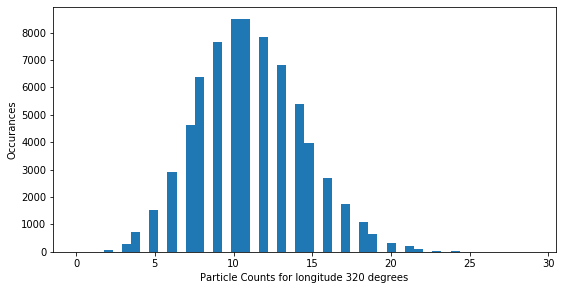

In [49]:
# First we need to make a histogram
figure = plt.figure(figsize=(9, 4.5))
ax = figure.subplots()
ax.set_xlabel("Particle Counts for longitude 320 degrees");
ax.set_ylabel("Occurances");

# In the previous section, I found that there was a spike in counts at about
# 320 degrees longitude. Lets go directly to that
peak_particles = particle_count[np.floor(longitude) == 320]
n, bins, _patches = ax.hist(peak_particles, bins=50);

# n contains the occurances at each particle count bin
bin_max = np.where(n == n.max())
max_count = bins[bin_max]
mu = max_count.sum() / len(max_count)
print("The mean of the particle count at longitude 320 degrees is " + str(mu))

# Lets also calculate the time this occurs at in the first cycle
time320d = delta_t * (320 / delta_l)
print("The time this occurs at is " + str(time320d) + " seconds")

In [51]:
# Having found this mean, we can then construct the model
from scipy.stats import poisson

poisson.pmf()

4) Because the background varies, your discovery sensitivity threshold (how many particles you would need to see) also varies. What is the '5-sigma' threshold for a 100 millisecond GRB at different times?

## Problem 2

In this problem we are going to look at a stack of telescope images (again simulated). We have 10 images, but you and your lab partner will be looking for different signals. One of you will be looking for the faintest stars, while the other will be looking for a transient (something like a super novae that only appears in one image). Flip a coin to determine which of you is pursuing which question.

1) Dowload the data from `images.h5`. This is a stack of 10 square images, each 200 pixels on a side.

2) Explore the data. Is there signal contamination? Is the background time dependent? Is it consistent spatially? Develop a plan to calculate your background pdf().

3) Using your background distribution, hunt for your signal (either faint stars, or a transient). Describe what you find.

4) You and your lab partner had different pdf(), but were using the same data. Explore why this is.